# Tutorial 9: Multitable 


In this tutorial, we will perform the avatarization of multitable dataset.

### Setup

In [2]:
import numpy as np
import pandas as pd
import io

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import os

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

# This is the client that you'll be using for all of your requests
from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters, PrivacyMetricsMultiTableJobCreate, AvatarizationMultiTableJobCreate, BasePrivacyMetricsParameters
from avatars.models import ReportCreate,SignalMetricsJobCreate,SignalMetricsParameters
from avatars.models import TableReference, TableLink, PrivacyMetricsParameters, PrivacyMetricsMultiTableParameters, AvatarizationMultiTableParameters,BaseAvatarizationParameters

# Change this to your actual server endpoint, e.g. base_url="https://avatar.company.com"
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

# Verify that we can connect to the API server
client.health.get_health()

{'message': 'ok'}

## Loading data

In this tutorial, we will avatarise data that contains a patient table, a doctor table and a visit table 
- There is 150 patients and only 130 of them did at least one visit
- There is 50 doctors, they all did at least ne visit 
- There is 300 visits

<img src="img/multitable.png" style="height:500px" />

In [24]:
game = pd.read_csv("../fixtures/game.csv", sep=",")[["game_id", "home_team_id", "away_team_id", "date_time_GMT"]]
player = pd.read_csv("../fixtures/player_info.csv", sep=",")[["player_id","height_cm", "weight", "shootsCatches"]]
team = pd.read_csv("../fixtures/team_info.csv", sep=",")[['team_id']]
game_stats = pd.read_csv("../fixtures/game_goalie_stats.csv", sep=",")[[ "game_id", "player_id", "shots", "saves"]]


In [25]:
game_stats

,game_id,player_id,shots,saves
0,2016020045,8473607,16,12
1,2016020045,8473461,11,9
2,2016020045,8470645,27,23
3,2017020812,8468011,33,30
4,2017020812,8475215,33,29
...,...,...,...,...
56651,2018030416,8476412,31,27
56652,2018030417,8476412,33,32
56653,2018030417,8471695,20,16
56654,2018030417,8476412,33,32


In [19]:
game

,game_id,home_team_id,away_team_id,date_time_GMT
0,2016020045,16,4,2016-10-19T00:30:00Z
1,2017020812,7,24,2018-02-07T00:00:00Z
2,2015020314,52,21,2015-11-24T01:00:00Z
3,2015020849,12,52,2016-02-17T00:00:00Z
4,2017020586,24,20,2017-12-30T03:00:00Z
...,...,...,...,...
26300,2018030415,6,19,2019-06-07T00:00:00Z
26301,2018030416,19,6,2019-06-10T00:00:00Z
26302,2018030416,19,6,2019-06-10T00:00:00Z
26303,2018030417,6,19,2019-06-13T00:00:00Z


In [20]:
player

,player_id,height_cm,weight,shootsCatches
0,8466148,185.42,207.0,L
1,8465058,185.42,210.0,R
2,8476906,180.34,180.0,L
3,8466285,177.80,192.0,L
4,8470607,190.50,220.0,R
...,...,...,...,...
3920,8479374,177.80,205.0,L
3921,8479403,185.42,185.0,L
3922,8480970,193.04,200.0,L
3923,8477574,185.42,185.0,L


In [21]:
team

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6
5,3,10,NY Rangers,Rangers,NYR,/api/v1/teams/3
6,5,17,Pittsburgh,Penguins,PIT,/api/v1/teams/5
7,17,12,Detroit,Red Wings,DET,/api/v1/teams/17
8,28,29,San Jose,Sharks,SJS,/api/v1/teams/28
9,18,34,Nashville,Predators,NSH,/api/v1/teams/18


To avatarise data we need to specify the links between tables, whether the table is an individual level and the identifier_variables 

In [27]:
dataset_patient = client.pandas_integration.upload_dataframe(
    patient,
    name="patient",
    identifier_variables=[
        "patient_id",
    ],
)

dataset_doctor = client.pandas_integration.upload_dataframe(
    doctor,
    name="doctor",
    identifier_variables=[
        "doctor_id",
    ],
)

dataset_visit = client.pandas_integration.upload_dataframe(
    visit,
    name="visit",
    identifier_variables=["visit_id", "patient_id", "doctor_id"],
)

doctor_ref = TableReference(
    dataset_id=dataset_doctor.id,
    is_individual_level=True,
)
patient_ref = TableReference(
    dataset_id=dataset_patient.id,
    is_individual_level=True,
)
visit_ref = TableReference(
    dataset_id=dataset_visit.id,
    is_individual_level=False,
)

table_links = [
    TableLink(
        parent_table=patient_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="patient_id",
        child_link_key="patient_id",
    ),
    TableLink(
        parent_table=doctor_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="doctor_id",
        child_link_key="doctor_id",
    ),
]


### Anonymization

In [28]:

avat_parameters = [
    
        BaseAvatarizationParameters(dataset_id=dataset_patient.id, k=10),
        BaseAvatarizationParameters(dataset_id=dataset_doctor.id, k=5),
        BaseAvatarizationParameters(dataset_id=dataset_visit.id, k=20),
]

avat_job = client.jobs.create_avatarization_multi_table_job(
    AvatarizationMultiTableJobCreate(
        parameters=AvatarizationMultiTableParameters(
            table_links=table_links, table_parameters=avat_parameters
        )
    )
)

avat_job = client.jobs.get_avatarization_multi_table_job(avat_job.id, timeout=1000)
results = avat_job.result.datasets
avatars_df = {}
for i, result in enumerate(results):
    avatars = client.pandas_integration.download_dataframe(
        result.avatars_dataset.id, should_stream=False
    )
    avatars_df[i]= avatars
    

In [29]:
client.jobs.get_avatarization_multi_table_job(avat_job.id, timeout=1000)

AvatarizationMultiTableJob(id=UUID('54b4aca9-7ee7-445d-b37f-684d570f2949'), kind=<JobKind.avatarization_multi_table: 'avatarization_multi_table'>, created_at=datetime.datetime(2024, 2, 15, 11, 33, 17, 987527, tzinfo=TzInfo(UTC)), status=<JobStatus.success: 'success'>, error_message=None, traceback=None, result=AvatarizationMultiTableResult(datasets=[AvatarizationResultPerDataset(privacy_metrics=None, signal_metrics=None, avatars_dataset=Dataset(id=UUID('9b1f4f11-a89c-4908-aed9-98372a4a5c16'), hash='f6596aee7f066465beab8b09e99e9252b34a34f40577dc3ee7d6e35d0dc746ce', name=None, columns=[ColumnDetail(type=<ColumnType.identifier: 'identifier'>, label='patient_id'), ColumnDetail(type=<ColumnType.category: 'category'>, label='gender'), ColumnDetail(type=<ColumnType.float: 'float'>, label='height'), ColumnDetail(type=<ColumnType.float: 'float'>, label='age'), ColumnDetail(type=<ColumnType.float: 'float'>, label='weight')], download_url='http://localhost:8000/datasets/9b1f4f11-a89c-4908-aed9-98

In [8]:
patient_avatar = avatars_df[0]
patient_avatar

,patient_id,gender,height,age,weight
0,63,Male,177.873191,59.282737,70.344550
1,91,Male,178.478445,64.296628,84.741770
2,45,Female,161.015543,73.839706,64.284821
3,133,Male,176.692056,58.654958,73.243804
4,16,Female,170.025052,70.697310,65.511512
...,...,...,...,...,...
145,123,Male,179.397664,59.443446,92.123794
146,119,Female,143.548913,72.151503,48.373323
147,40,Male,175.264436,57.161349,90.551599
148,96,Female,170.981938,73.758952,78.044374


In [9]:
doctor_avatar = avatars_df[1]
doctor_avatar

,doctor_id,job,age
0,4,general practitioner,56.864295
1,45,pediatrician,47.631652
2,37,general practitioner,49.702341
3,36,general practitioner,46.148276
4,14,pediatrician,37.689448
5,18,general practitioner,66.680462
6,39,pediatrician,49.376934
7,13,general practitioner,50.064166
8,1,general practitioner,56.766972
9,6,general practitioner,57.702243


In [10]:
visit_avatar = avatars_df[2]
visit_avatar

,visit_id,patient_id,doctor_id,day_visit,exam
0,21,0,8,Wednesday,routine_check
1,122,0,38,Thursday,vaccine
2,296,2,24,Tuesday,vaccine
3,164,2,28,Thursday,vaccine
4,9,2,48,Thursday,routine_check
...,...,...,...,...,...
295,275,147,15,Wednesday,vaccine
296,147,148,44,Thursday,routine_check
297,114,148,16,Tuesday,routine_check
298,255,148,26,Tuesday,vaccine


### Privacy metric computation

In [11]:
privacy_parameters = parameters = [
    BasePrivacyMetricsParameters(
        original_id=dataset_patient.id,
        unshuffled_avatars_id=results[0].sensitive_unshuffled_avatars_datasets.id,
    ),
    BasePrivacyMetricsParameters(
        original_id=dataset_doctor.id,
        unshuffled_avatars_id=results[1].sensitive_unshuffled_avatars_datasets.id,
    ),
    BasePrivacyMetricsParameters(
        original_id=dataset_visit.id,
        unshuffled_avatars_id=results[2].sensitive_unshuffled_avatars_datasets.id,
    ),
]

privacy_job = client.jobs.create_privacy_metrics_multi_table_job(
    PrivacyMetricsMultiTableJobCreate(
        parameters=PrivacyMetricsMultiTableParameters(
            table_links=table_links,
            table_parameters=privacy_parameters,
        )
    )
)

privacy_job = client.jobs.get_privacy_metrics_multi_table_job(privacy_job.id, timeout=1000)


In [41]:
privacy_metrics = privacy_job.result.details
print("*** Privacy metrics ***")
for metric in privacy_metrics:
    print('--------')
    print(metric)

*** Privacy metrics ***
--------
hidden_rate=100.0 local_cloaking=1.0 distance_to_closest=0.0 closest_distances_ratio=0.0 column_direct_match_protection=96.0 categorical_hidden_rate=100.0 row_direct_match_protection=100.0 correlation_protection_rate=None inference_continuous=None inference_categorical=None closest_rate=None targets=PrivacyMetricsTargets(hidden_rate='> 90', local_cloaking='> 5', distance_to_closest='> 0.2', closest_distances_ratio='> 0.3', column_direct_match_protection='> 50', categorical_hidden_rate='> 90', row_direct_match_protection='> 90', correlation_protection_rate='> 95', inference_continuous='> 10', inference_categorical='> 10', closest_rate='> 90') original_id=UUID('4de9b4ca-532e-4a30-be2d-bd04774b2bf1') unshuffled_avatars_id=UUID('a688443b-0b69-4c3c-a07c-7f32c6fc3094') metrics_type='multi_table' individual_identifier_variable='doctor.doctor_id' computation_type=<PrivacyMetricsComputationType.standalone: 'standalone'> dataset_name='doctor'
--------
hidden_rate

In [12]:
index = ['doctor_standalone', 'patient_standalone', 
                      'visit_to_bottom_id_propagated_doctor.doctor_id', 'visit_to_bottom_id_propagated_patient.patient_id',
                      'doctor_to_top_enriched_doctor.doctor_id', 'patient_to_top_enriched_patient.patient_id',
                      'visit_full_enriched_doctor.doctor_id','visit_full_enriched_patient.patient_id']
privacy_job
data=privacy_job.result.details
data_dict = {
    'Hidden Rate': [round(d.hidden_rate,2) for d in data],
    'Local Cloaking': [round(d.local_cloaking,2) for d in data],
    'Distance to Closest': [round(d.distance_to_closest,4) for d in data],
    'Closest Distances Ratio': [round(d.closest_distances_ratio,4) for d in data],
    'Column Direct Match Protection': [round(d.column_direct_match_protection,2) for d in data],
    'Categorical Hidden Rate': [round(d.categorical_hidden_rate,2) for d in data],
    'Row Direct Match Protection': [round(d.row_direct_match_protection,2) for d in data],
    'Table': [d.dataset_name + "_" + d.computation_type.name + ("_" + d.individual_identifier_variable if d.computation_type.name !="standalone" else "") for d in data], 
 }

df = pd.DataFrame(data_dict)
df.set_index('Table', inplace=True)
df= df.reindex(index)
df.loc['TARGET',:]=[90,5,0.2,0.3,50,90,90]

In [13]:
df

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
doctor_standalone,100.00,1.0,0.0000,0.0000,96.00,100.00,100.0
patient_standalone,100.00,1.0,0.0000,0.0000,98.67,100.00,100.0
visit_to_bottom_id_propagated_doctor.doctor_id,100.00,19.0,0.0000,1.0000,98.36,100.00,0.0
visit_to_bottom_id_propagated_patient.patient_id,100.00,25.0,0.0000,1.0000,98.36,100.00,0.0
doctor_to_top_enriched_doctor.doctor_id,90.00,8.0,0.7492,0.7471,95.60,66.67,100.0
patient_to_top_enriched_patient.patient_id,94.67,35.5,0.7272,0.7370,98.44,100.00,100.0
visit_full_enriched_doctor.doctor_id,87.33,15.0,0.0000,0.0000,98.36,100.00,100.0
visit_full_enriched_patient.patient_id,90.33,22.5,0.0000,0.0000,98.36,100.00,100.0
TARGET,90.00,5.0,0.2000,0.3000,50.00,90.00,90.0


## Univariate comparison 

You can here compare distributions between original and avatar data.  
If distributions are not well preserved, you can work with the parameter `columns_weight` in your avatarization.

### Patient

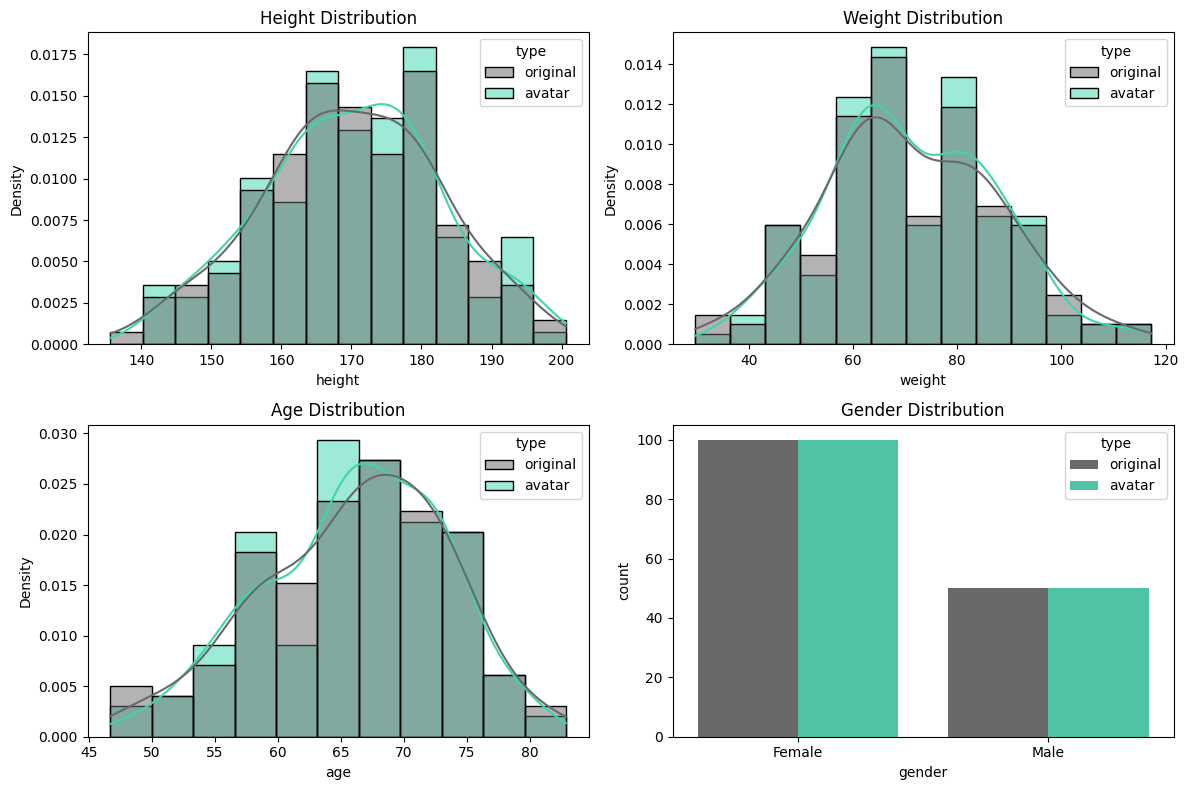

In [14]:
patient_combined = pd.concat([patient, patient_avatar]).reset_index(drop=True)
patient_combined['type'] = np.repeat(['original', 'avatar'], 150)
map_color= {'original':'dimgrey', 'avatar':'#3BD6B0'}
# Distribution continuous sur la même sortie 
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=patient_combined, x='height', hue="type", palette=map_color, kde=True, ax=axes[0, 0], stat="density")
#sns.kdeplot(data=patient_combined, x='height', hue="type", palette=map_color,  ax=axes[0, 0])
sns.histplot(data=patient_combined, x='weight', hue="type", palette=map_color, kde=True, ax=axes[0, 1], stat="density")
#sns.kdeplot(data=patient_combined, x='weight', hue="type", palette=map_color,ax=axes[0, 1])
sns.histplot(data=patient_combined, x='age', hue="type", palette=map_color, kde=True, ax=axes[1, 0], stat="density")
#sns.kdeplot(data=patient_combined, x='age', hue="type", palette=map_color, ax=axes[1, 0])
sns.countplot(data=patient_combined, x='gender',hue='type',  palette=map_color, ax=axes[1, 1])

axes[0, 0].set_title('Height Distribution')
axes[0, 1].set_title('Weight Distribution')
axes[1, 0].set_title('Age Distribution')
axes[1, 1].set_title('Gender Distribution')
plt.tight_layout()
plt.show()

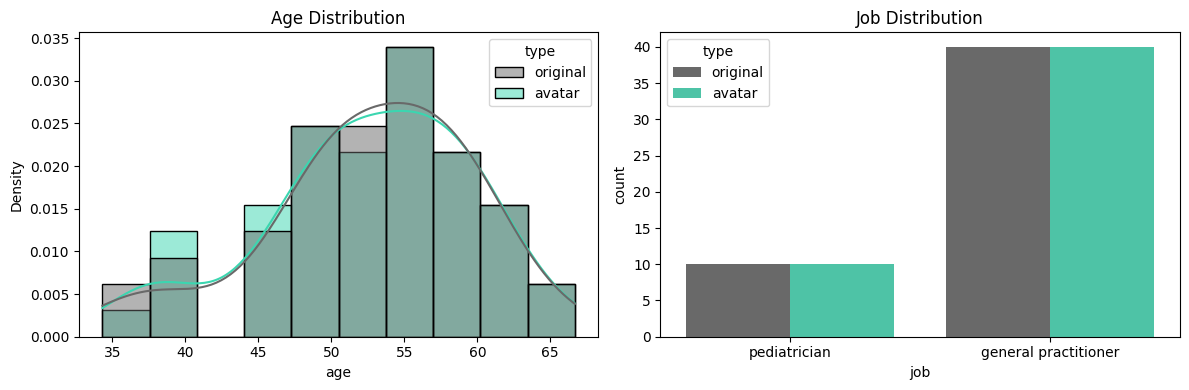

In [15]:
doctor_combined = pd.concat([doctor, doctor_avatar]).reset_index(drop=True)
doctor_combined['type'] = np.repeat(['original', 'avatar'], 50)
map_color= {'original':'dimgrey', 'avatar':'#3BD6B0'}
# Distribution continuous sur la même sortie 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=doctor_combined, x='age', hue="type", palette=map_color, kde=True, ax=axes[0], stat="density")
sns.countplot(data=doctor_combined, x='job',hue='type',  palette=map_color, ax=axes[1])

axes[0].set_title('Age Distribution')
axes[1].set_title('Job Distribution')
plt.tight_layout()
plt.show()

<Axes: xlabel='exam', ylabel='count'>

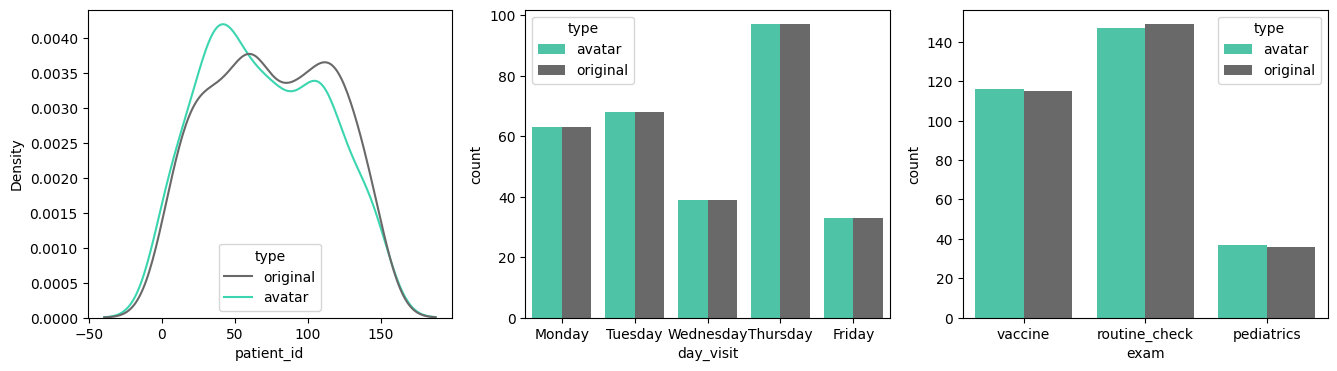

In [16]:
visit_combined = pd.concat([visit, visit_avatar]).reset_index(drop=True)
visit_combined['type'] = np.repeat(['original', 'avatar'], 300)
map_color= {'original':'dimgrey', 'avatar':'#3BD6B0'}
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.kdeplot(data=visit_combined, x='patient_id', hue="type", ax=axes[0], palette=map_color)
day_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
visit_combined['day_visit'] = pd.Categorical(visit_combined['day_visit'], categories=day_order, ordered=True)
visit_combined=visit_combined.sort_values('day_visit')
sns.countplot(data=visit_combined, x='day_visit',hue='type',  palette=map_color, ax=axes[1])
sns.countplot(data=visit_combined, x='exam',hue='type',  palette=map_color, ax=axes[2])


## Multivariate comparison 


### Visit x Patient

In [20]:
doctor_avatar_renamed = doctor_avatar.rename(columns={"age": "age_doctor"})
visit_avatar_flat = visit_avatar.join(
        doctor_avatar_renamed.set_index("doctor_id"), on="doctor_id"
    )
visit_avatar_flat = visit_avatar_flat.join(
        patient_avatar.set_index("patient_id"), on="patient_id"
    )


doctor_renamed = doctor.rename(columns={"age": "age_doctor"})
visit_flat = visit.join(
        doctor_renamed.set_index("doctor_id"), on="doctor_id"
    )
visit_flat = visit_flat.join(
        patient.set_index("patient_id"), on="patient_id"
    )



Text(0.5, 1.0, 'Avatar')

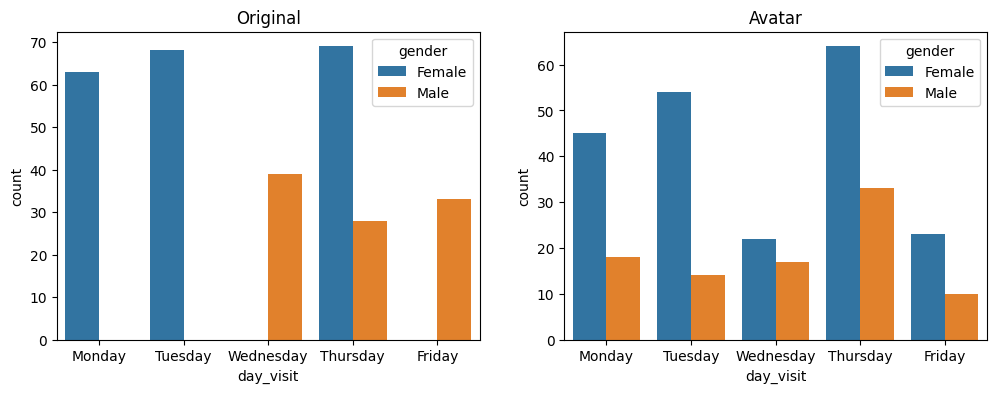

In [21]:
visit_flat['day_visit'] = pd.Categorical(visit_flat['day_visit'], categories=day_order, ordered=True)
visit_flat=visit_flat.sort_values('day_visit')
visit_avatar_flat['day_visit'] = pd.Categorical(visit_avatar_flat['day_visit'], categories=day_order, ordered=True)
visit_avatar_flat=visit_avatar_flat.sort_values('day_visit')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=visit_flat,x='day_visit',hue="gender",ax=axes[0])
sns.countplot(data=visit_avatar_flat,x='day_visit',hue="gender",ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Avatar')

### Visit x Doctor

Text(0.5, 1.0, 'Avatar')

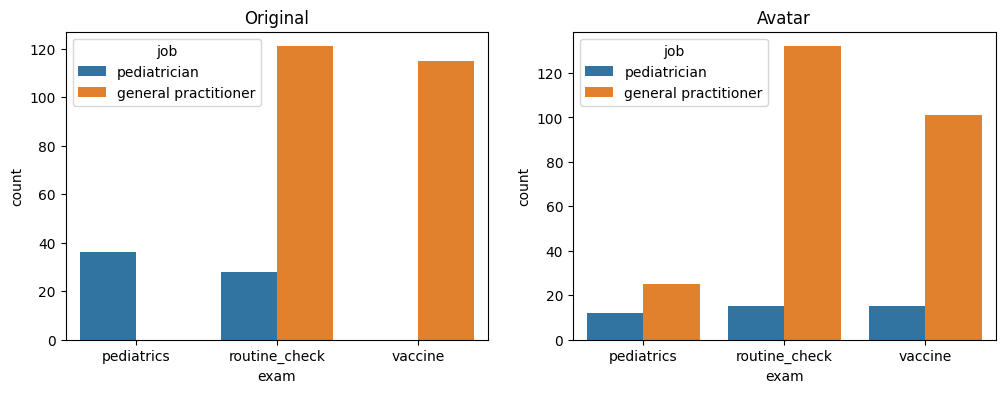

In [30]:
visit_avatar_flat=visit_avatar_flat.sort_values('exam')
visit_flat=visit_flat.sort_values('exam')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=visit_flat,x='exam',hue="job",ax=axes[0])
sns.countplot(data=visit_avatar_flat,x='exam',hue="job",ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Avatar')